# Builing a time series model
* Joakim Blix Prestmo
* 09.05.2018
## Models
* Starting with error correction model
* Continue with a GMM apporach
* Finishing with a Threashold model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.sandbox.regression import gmm

from statsmodels.tsa.vector_ar.var_model import VAR

#from arch.unitroot import DFGLS

SyntaxError: invalid syntax (client.py, line 1063)

In [55]:
df = pd.read_csv('samlet_datasett_10092017.csv')


In [56]:
dates = pd.date_range('19840101', periods=132, freq='Q')

#dates = pd.date_range('20130101', periods=4, freq='MS')
df.index=dates


In [57]:
df.index = pd.DatetimeIndex(df.index)
df.drop('Unnamed: 0', 1, inplace=True)

In [58]:
ols_data_est=df[:-4]
ols_data_est.tail()

,K1015,K4015,K5015,K1025,K4025,K5025,K1030,K4030,K5030,K1045,...,DRRT,DRRT_1,DRRT_2,DRRT_3,DRRT_4,DUC,DUC_1,DUC_2,DUC_3,DUC_4
2014-12-31,45008.63335,1228.63344,26863.91132,59655.72159,1861.50703,31505.95344,57451.07448,403.80079,33492.49197,32638.62799,...,0.001063,-0.003022,0.002679,0.001861,0.006631,-0.551075,0.210360,1.500469,-2.615974,-1.524003
2015-03-31,44710.30725,1191.80247,26561.60836,59232.71540,1818.56478,30824.29604,57026.93180,393.97402,33001.70482,32477.86500,...,-0.000210,0.001063,-0.003022,0.002679,0.001861,-0.863427,-0.551075,0.210360,1.500469,-2.615974
2015-06-30,44660.74877,1164.56761,26428.23710,59028.06353,1802.96125,30519.94567,56712.87368,397.61474,32731.88960,32285.78419,...,-0.003019,-0.000210,0.001063,-0.003022,0.002679,-0.060014,-0.863427,-0.551075,0.210360,1.500469
2015-09-30,44585.25589,1133.09735,26149.56614,58657.08984,1754.94256,29993.58201,56477.97224,415.79142,32508.87342,32054.57948,...,0.002397,-0.003019,-0.000210,0.001063,-0.003022,-0.979236,-0.060014,-0.863427,-0.551075,0.210360
2015-12-31,44556.66137,1136.89896,26177.23213,58369.50351,1716.33108,29789.86767,56254.37121,418.17763,32914.92901,31864.73983,...,-0.005768,0.002397,-0.003019,-0.000210,0.001063,0.102864,-0.979236,-0.060014,-0.863427,-0.551075


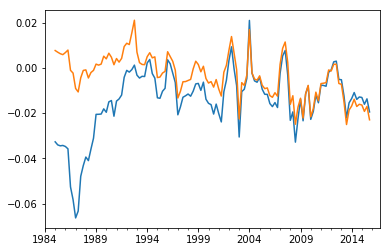

In [59]:
df['RRT'].plot()
(df['RNOK']-df['KPI'].diff(4)).plot()
plt.show()

# Error correction

In [60]:
formel = 'Dlog_JK3 ~ 1 + Dlog_JK3_3 +Dlog_X3_3 + Dlog_YE_Y3_1+ log_JK3_1 + log_X3_1 + log_YE_Y3_3 + S_1 + DKV1 + DKV2 + DKV3'

ECmodel = smf.ols(formel, data = ols_data_est)
result = ECmodel.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               Dlog_JK3   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     78.60
Date:                Thu, 24 May 2018   Prob (F-statistic):           3.86e-46
Time:                        09:43:45   Log-Likelihood:                 126.45
No. Observations:                 124   AIC:                            -230.9
Df Residuals:                     113   BIC:                            -199.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.6692      0.576      2.898   

# GMM 

In [61]:
df['log_JK3_lead']=df['log_JK3'].shift(-1)
df['RRT_lead']=df['RRT'].shift(-1)
df['const']=1

In [62]:
endog_df=df[['RRT_lead', 'log_JK3_lead', 'log_JK3']]
exog_df = endog_df #df[['RRT','S',  'log_YE_Y3', 'log_X3' ]]

In [63]:
instrument_df = df[['RRT_1', 'RRT_2', 'log_JK3_1', 'Dlog_JK3_1', 'Dlog_JK3_2',
                           'const']]

In [64]:
endog, exog, instrument  = map(np.asarray, [endog_df, exog_df, instrument_df])

In [67]:
def moment_invest(params, exog):
    beta, gamma = params
    #endog, exog = args
    RRT_lead, log_JK3_lead, log_JK3 = exog.T  # unwrap iterable (ndarray)
    
    # 2nd part of moment condition without instrument    
    predicted = beta * (1. + RRT_lead) * np.power(log_JK3_lead / log_JK3, gamma)
    return predicted




In [71]:
endog2 = np.ones(exog.shape[0])    
mod = gmm.NonlinearIVGMM(endog2, exog, instrument, moment_invest)
#w0inv = np.dot(instrument.T, instrument) / len(endog2)  
#res2_hac4_2s = mod2.fit([1,-1], maxiter=2, inv_weights=w0inv, weights_method='hac', wargs={'maxlag':4})

C:\Users\jop\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1591: RuntimeWarning: invalid value encountered in greater
  return sum(S > tol)


# Maximum likelihood

# Threshold model 

In [29]:
# building threshold variables
medianDx3 = ols_data_est['Dlog_X3_4'].median()
highDx3 = ols_data_est['Dlog_X3_4'] >= medianDx3
highmedianDx3 = medianDx3*(-10)
higherDx3 = ols_data_est['Dlog_X3_4'] >= highmedianDx3
HDUMX3 = higherDx3
# **************************
medianDYE_Y = ols_data_est['Dlog_YE_Y3_4'].median()
highDYE_Y3 = ols_data_est['Dlog_YE_Y3_4'] >= medianDYE_Y
highmedianDYE_Y = medianDYE_Y*(-10)
higherDYE_Y = ols_data_est['Dlog_YE_Y3_4'] >= highmedianDYE_Y
HDUMYE_Y= higherDYE_Y



In [33]:
TARmodel = smf.ols('Dlog_JK3 ~ 1 + Dlog_JK3_1 + log_JK3_1 + (HDUMYE_Y)*Dlog_YE_Y3_1 + HDUMX3*log_X3_1 + (HDUMYE_Y)*log_YE_Y3_1', 
                   data = ols_data_est)
result = TARmodel.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               Dlog_JK3   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     29.13
Date:                Wed, 09 May 2018   Prob (F-statistic):           4.43e-27
Time:                        22:21:36   Log-Likelihood:                 77.916
No. Observations:                 126   AIC:                            -133.8
Df Residuals:                     115   BIC:                            -102.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     